# Replication Report: "Effectiveness of Mask Wearing and Vaccination in Reducing COVID-19 Spread in Virginia Schools"

Sydney Tune, Mason Davis, Lauryn McCray, YoungJae Kim, Isaiah Medina 

This report provides background and instructions regarding the replication of our study, "Effectiveness of Mask Wearing and Vaccination in Reducing COVID-19 Spread in Virginia Schools".

## The SIRED Model



To examine the effects of masks and vaccinations on COVID-19 spread among K-12 Virginian schools, we use Python to create an SIRED model. SIRED stands for Susceptible, Infected, Recovered, Exposed and Dead. Individuals in our population (K-12 students; adult faculty and staff) will always fall into one of these groups. When an individual comes in contact with an infected person, they are newly categorized as ‘exposed.’ When the exposed themselves contract the virus, they are moved to the ‘infected’ group, then to the ‘recovered’ group upon recovery or ‘dead’ upon death. Recovered individuals are considered ‘susceptible’ again. The infected group amplifies the transmission process by continuing to put susceptible people at risk of exposure and infection.

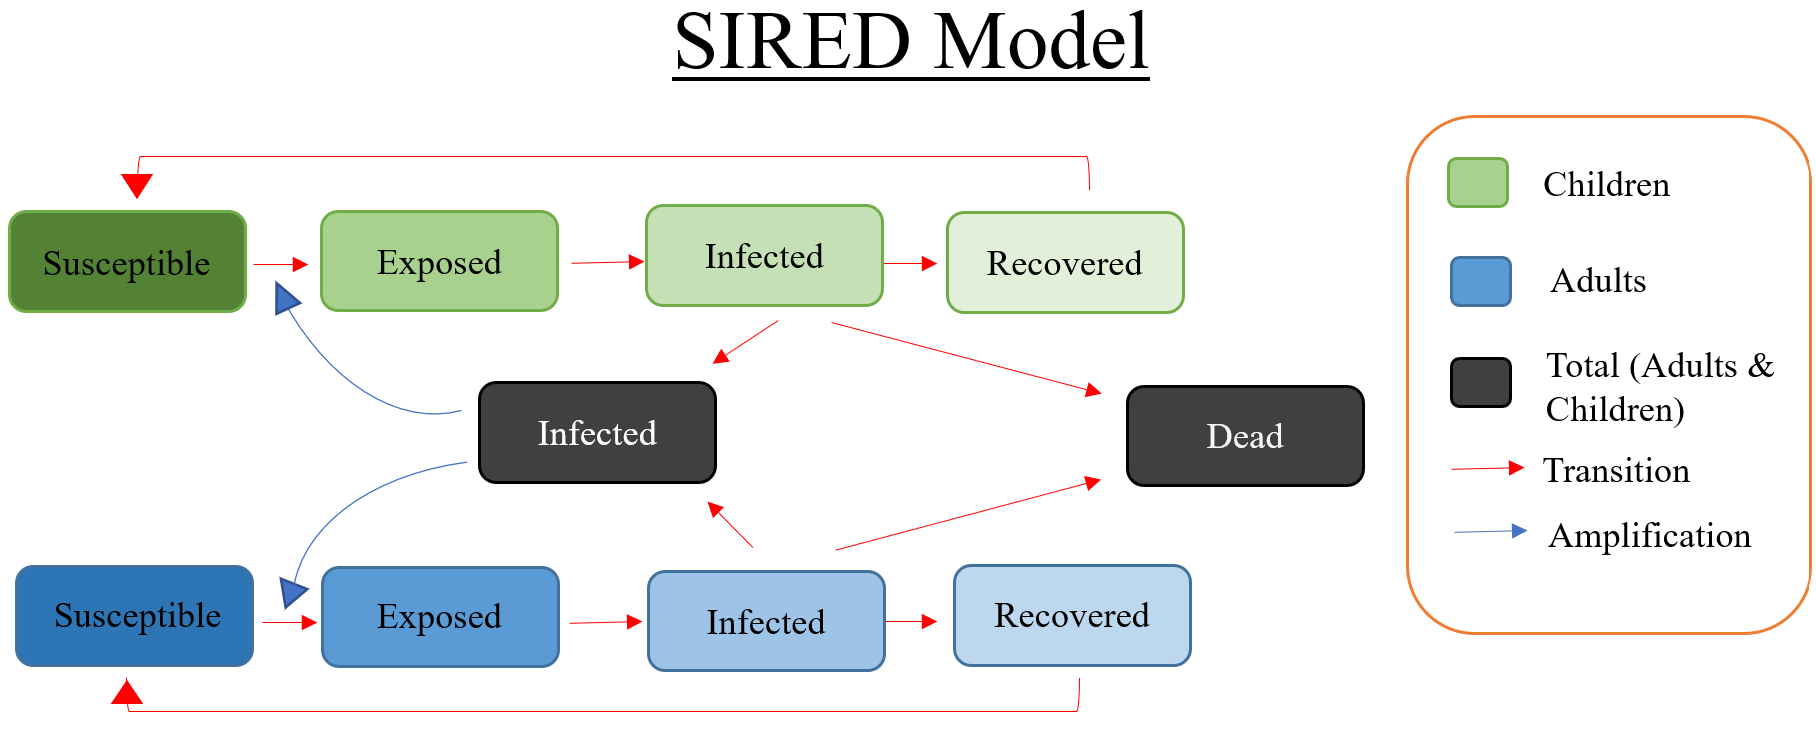

## Established Parameters

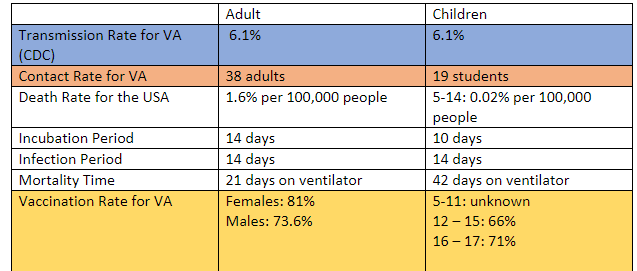

We also had to come up with certain parameters and values needed for the model. The table above depicts the parameters that you will find in the following code for each of our simulations.The first variable we calculated was contact rate for children, which was just the average class size across Virginia. The contact rate for adults was determined as double the contact rate for children, as teachers see 2 classes per day. 

In the code we defined many of the parameter values that we calculated by hand (contact rate) as well as imported values that we received from sources like the CDC (transmissibility, mortality time, infection period, and incubation period).

## Code to reproduce simulations

NOTE: In order to reproduce figures, the following libraries and modules should be imported using Anaconda. If Jupyter Notebook is used, not all libraries may be imported properly.

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.integrate import odeint

# Simulation without intervention 

For our first simulation and all following simulations, we are assuming that 70% of the adults in our subpopulation are vaccinated at the beginning of the school year, given that vaccines have been available for a long period of time, and virginia reports have 80% of women and 73.6% of men being vaccinated.

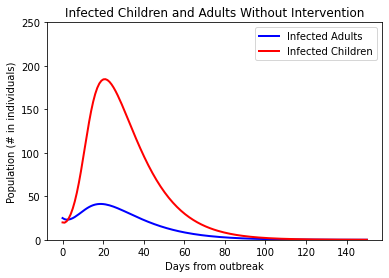

In [27]:
# Infected children and adult populations without any intervention
#contact rate (individuals/day)
cont_rate_c= 19
cont_rate_a= 38

#transmissibility of the disease
trans_c = .061
trans_a = .061

#infectious perIod (days) 
inf_period_c = 14
inf_period_a = 14

#incubation period (days)
inc_period_c = 10
inc_period_a = 14

#
mort_time_c = 42
mort_time_a = 21

# solve the system dy/dt = f(y, t)
def f(y, t):
        #assign input vector,y to variables of the model
        S_c = y[0]
        I_c = y[1]
        R_c = y[2]
        E_c = y[3]
        D_c = y[4]
        S_a = y[5]
        I_a = y[6]
        R_a = y[7]
        E_a = y[8]
        D_a = y[9]
        
        # Calculate total population size,N
        N_c = I_c + S_c + R_c +E_c + D_c
        N_a =  I_a +S_a+R_a+E_a+D_a
        N= I_c + S_c + R_c +E_c + D_c + I_a +S_a+R_a+E_a+D_a

        # Parameters of SIR model
        r_r_c = 1/inf_period_c
        r_i_c = cont_rate_c*trans_c / N_c
        r_e_c = 1 / inc_period_c
        r_d_c = .003 / mort_time_c
        
        r_r_a = 1/inf_period_a
        r_i_a = cont_rate_a*trans_a / N_a
        r_e_a = 1 / inc_period_a
        r_d_a = .014 / mort_time_a
        
        # Fine right hand side of differential equations
        dS_c = (-r_i_c*S_c*(I_c + I_a)) 
        dI_c = r_e_c*E_c - r_r_c * I_c - r_d_c * I_c
        dR_c = r_r_c*I_c 
        dE_c = r_i_c *I_c*S_c - r_e_c*E_c 
        dD_c = r_d_c * I_c 
        
        dS_a = (-r_i_a*S_a*(I_c + I_a)) 
        dI_a = r_e_a*E_a - r_r_a * I_a - r_d_a * I_a
        dR_a = r_r_a*I_a 
        dE_a = r_i_a *I_a*S_a - r_e_a*E_a
        dD_a = r_d_a * I_a
        
        # output right-hand side of differetial equations
        return [dS_c, dI_c, dR_c, dE_c, dD_c, dS_a, dI_a, dR_a, dE_a, dD_a]


# Choose total time of simulation, T
T = 150

# Chose time step
dt = 1

#Calculate number of time steps
nsteps = int(T/dt)

# Create time grid
t  = np.linspace(0, T, nsteps) 

# Choose initial conditions
S0_c = 700.
I0_c = 20.
R0_c = 0.
E0_c = 0
D0_c = 0
S0_a = 280.
I0_a = 25.
R0_a = 980. #(70% vaxed adults)
E0_a = 0
D0_a = 0


y0 = [S0_c, I0_c, R0_c, E0_c, D0_c, S0_a, I0_a, R0_a, E0_a, D0_a]       


# solve system of differential equations
soln = odeint(f, y0, t)
#print(soln)
#assign solution vector,soln, to plotting variables
S_c = soln[:, 0]
I_c = soln[:, 1]
R_c = soln[:, 2]
E_c = soln[:, 3]
D_c = soln[:, 4]
S_a = soln[:, 5]
I_a = soln[:, 6]
R_a = soln[:, 7]
E_a = soln[:, 8]
D_a = soln[:, 9]

S = S_c + S_a
I = I_c + I_a
R = R_c + R_a
E = E_c + E_a
D = D_c + D_a


plt.figure()
plt.plot(t, I_a, lw = 2, color = 'blue', label = 'Infected Adults')
plt.plot(t, I_c, 'red', lw = 2, label = 'Infected Children')
plt.title("Infected Children and Adults Without Intervention")
plt.xlabel("Days from outbreak")
plt.ylabel("Population (# in individuals)")
plt.ylim(0,250)

plt.legend(loc=0)

# Simulation for vaccine campaign 


Different rates of vaccination are placed into a list and run through the code for both populations, seperately and together. With all parameters and rates imported into the code, user is able to run code to produce the first two graphs regarding the number of infected students as well as the total population with different vaccination rates. The final graph shows the impact of COVID-19 infection if only a vaccination campaign was implemented.  

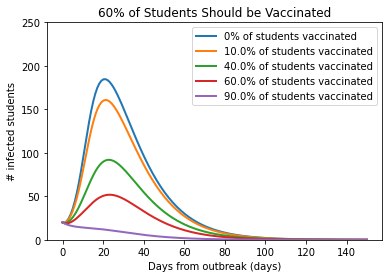

In [28]:
# Vaccine campaign impact on infection of students  
rates = [0, .1, .4, .6, .9]
for i in range(5):
    cont_rate_c= 19
    cont_rate_a= 38

    #transmissibility of the disease
    trans_c = .061
    trans_a = .061

    #infectious perIod (days) 
    inf_period_c = 14
    inf_period_a = 14

    #incubation period (days)
    inc_period_c = 10
    inc_period_a = 14

    #
    mort_time_c = 42
    mort_time_a = 21


    # solve the system dy/dt = f(y, t)
    def f(y, t):
        #assign input vector,y to variables of the model
        S_c = y[0]
        I_c = y[1]
        R_c = y[2]
        E_c = y[3]
        D_c = y[4]
        S_a = y[5]
        I_a = y[6]
        R_a = y[7]
        E_a = y[8]
        D_a = y[9]
        
        # Calculate total population size,N
        N_c = I_c + S_c + R_c +E_c + D_c
        N_a =  I_a +S_a+R_a+E_a+D_a
        N= I_c + S_c + R_c +E_c + D_c + I_a +S_a+R_a+E_a+D_a

        # Parameters of SIR model
        r_r_c = 1/inf_period_c
        r_i_c = cont_rate_c*trans_c / N_c
        r_e_c = 1 / inc_period_c
        r_d_c = .003 / mort_time_c
        
        r_r_a = 1/inf_period_a
        r_i_a = cont_rate_a*trans_a / N_a
        r_e_a = 1 / inc_period_a
        r_d_a = .014 / mort_time_a
        
        # Fine right hand side of differential equations
        dS_c = (-r_i_c*S_c*(I_c + I_a)) 
        dI_c = r_e_c*E_c - r_r_c * I_c - r_d_c * I_c
        dR_c = r_r_c*I_c 
        dE_c = r_i_c *I_c*S_c - r_e_c*E_c 
        dD_c = r_d_c * I_c 
        
        dS_a = (-r_i_a*S_a*(I_c + I_a)) 
        dI_a = r_e_a*E_a - r_r_a * I_a - r_d_a * I_a
        dR_a = r_r_a*I_a 
        dE_a = r_i_a *I_a*S_a - r_e_a*E_a
        dD_a = r_d_a * I_a
        
        # output right-hand side of differetial equations
        return [dS_c, dI_c, dR_c, dE_c, dD_c, dS_a, dI_a, dR_a, dE_a, dD_a]


    # Choose total time of simulation, T
    T = 150

    # Chose time step
    dt = 1

    #Calculate number of time steps
    nsteps = int(T/dt)

    # Create time grid
    t  = np.linspace(0, T, nsteps) 

    # Choose initial conditions
    S0_c = 700. * (1 - rates[i])
    I0_c = 20.
    R0_c = 700 - 700 * (1 - rates[i])
    E0_c = 0
    D0_c = 0
    S0_a = 280.
    I0_a = 25.
    R0_a = 980. #(70% vaxed adults)
    E0_a = 0
    D0_a = 0
    

    y0 = [S0_c, I0_c, R0_c, E0_c, D0_c, S0_a, I0_a, R0_a, E0_a, D0_a]       


    # solve system of differential equations
    soln = odeint(f, y0, t)
    #print(soln)
    #assign solution vector,soln, to plotting variables
    S_c = soln[:, 0]
    I_c = soln[:, 1]
    R_c = soln[:, 2]
    E_c = soln[:, 3]
    D_c = soln[:, 4]
    S_a = soln[:, 5]
    I_a = soln[:, 6]
    R_a = soln[:, 7]
    E_a = soln[:, 8]
    D_a = soln[:, 9]

    S = S_c + S_a
    I = I_c + I_a
    R = R_c + R_a
    E = E_c + E_a
    D = D_c + D_a


    # plot results
    plt.plot(t, I_c, lw = 2, label = str(rates[i] * 100) + "% of students vaccinated")

    plt.xlabel('Days from outbreak (days)')
    plt.ylabel('# infected students')
    plt.title('60% of Students Should be Vaccinated')
    plt.ylim(0,250)
    




plt.legend(loc=0)
plt.show()

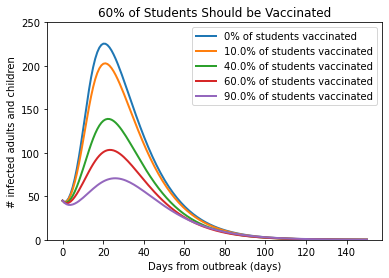

In [29]:
# Vaccine campaign impact on infection of total population 
rates = [0, .1, .4, .6, .9]
for i in range(5):
    cont_rate_c= 19
    cont_rate_a= 38

    #transmissibility of the disease
    trans_c = .061
    trans_a = .061

    #infectious perIod (days) 
    inf_period_c = 14
    inf_period_a = 14

    #incubation period (days)
    inc_period_c = 10
    inc_period_a = 14

    #
    mort_time_c = 42
    mort_time_a = 21


    # solve the system dy/dt = f(y, t)
    def f(y, t):
        #assign input vector,y to variables of the model
        S_c = y[0]
        I_c = y[1]
        R_c = y[2]
        E_c = y[3]
        D_c = y[4]
        S_a = y[5]
        I_a = y[6]
        R_a = y[7]
        E_a = y[8]
        D_a = y[9]
        
        # Calculate total population size,N
        N_c = I_c + S_c + R_c +E_c + D_c
        N_a =  I_a +S_a+R_a+E_a+D_a
        N= I_c + S_c + R_c +E_c + D_c + I_a +S_a+R_a+E_a+D_a

        # Parameters of SIR model
        r_r_c = 1/inf_period_c
        r_i_c = cont_rate_c*trans_c / N_c
        r_e_c = 1 / inc_period_c
        r_d_c = .003 / mort_time_c
        
        r_r_a = 1/inf_period_a
        r_i_a = cont_rate_a*trans_a / N_a
        r_e_a = 1 / inc_period_a
        r_d_a = .014 / mort_time_a
        
        # Fine right hand side of differential equations
        dS_c = (-r_i_c*S_c*(I_c + I_a)) 
        dI_c = r_e_c*E_c - r_r_c * I_c - r_d_c * I_c
        dR_c = r_r_c*I_c 
        dE_c = r_i_c *I_c*S_c - r_e_c*E_c 
        dD_c = r_d_c * I_c 
        
        dS_a = (-r_i_a*S_a*(I_c + I_a)) 
        dI_a = r_e_a*E_a - r_r_a * I_a - r_d_a * I_a
        dR_a = r_r_a*I_a 
        dE_a = r_i_a *I_a*S_a - r_e_a*E_a
        dD_a = r_d_a * I_a
        
        # output right-hand side of differetial equations
        return [dS_c, dI_c, dR_c, dE_c, dD_c, dS_a, dI_a, dR_a, dE_a, dD_a]


    # Choose total time of simulation, T
    T = 150

    # Chose time step
    dt = 1

    #Calculate number of time steps
    nsteps = int(T/dt)

    # Create time grid
    t  = np.linspace(0, T, nsteps) 

    # Choose initial conditions
    S0_c = 700. * (1 - rates[i])
    I0_c = 20.
    R0_c = 700 - 700 * (1 - rates[i])
    E0_c = 0
    D0_c = 0
    S0_a = 280.
    I0_a = 25.
    R0_a = 980. #(70% vaxed adults)
    E0_a = 0
    D0_a = 0
    

    y0 = [S0_c, I0_c, R0_c, E0_c, D0_c, S0_a, I0_a, R0_a, E0_a, D0_a]       


    # solve system of differential equations
    soln = odeint(f, y0, t)
    #print(soln)
    #assign solution vector,soln, to plotting variables
    S_c = soln[:, 0]
    I_c = soln[:, 1]
    R_c = soln[:, 2]
    E_c = soln[:, 3]
    D_c = soln[:, 4]
    S_a = soln[:, 5]
    I_a = soln[:, 6]
    R_a = soln[:, 7]
    E_a = soln[:, 8]
    D_a = soln[:, 9]

    S = S_c + S_a
    I = I_c + I_a
    R = R_c + R_a
    E = E_c + E_a
    D = D_c + D_a


    
    plt.plot(t, I_a + I_c, lw = 2, label = str(rates[i] * 100) + "% of students vaccinated")

    plt.xlabel('Days from outbreak (days)')
    plt.ylabel('# infected adults and children')
    plt.title('60% of Students Should be Vaccinated')
    plt.ylim(0,250)

plt.legend(loc=0)
plt.show()


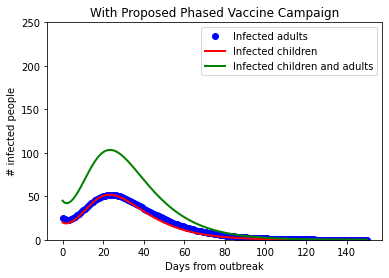

In [30]:
# Only implementing the proposed phased vaccination campaign
#contact rate (individuals/day)
cont_rate_c= 19
cont_rate_a= 38

#transmissibility of the disease
trans_c = .061
trans_a = .061

#infectious perIod (days) 
inf_period_c = 14
inf_period_a = 14

#incubation period (days)
inc_period_c = 10
inc_period_a = 14

#
mort_time_c = 42
mort_time_a = 21

# solve the system dy/dt = f(y, t)
def f(y, t):
        #assign input vector,y to variables of the model
        S_c = y[0]
        I_c = y[1]
        R_c = y[2]
        E_c = y[3]
        D_c = y[4]
        S_a = y[5]
        I_a = y[6]
        R_a = y[7]
        E_a = y[8]
        D_a = y[9]
        
        # Calculate total population size,N
        N_c = I_c + S_c + R_c +E_c + D_c
        N_a =  I_a +S_a+R_a+E_a+D_a
        N= I_c + S_c + R_c +E_c + D_c + I_a +S_a+R_a+E_a+D_a
        

        # Parameters of SIR model
        r_r_c = 1/inf_period_c
        r_i_c = cont_rate_c*trans_c / N_c
        r_e_c = 1 / inc_period_c
        r_d_c = .003 / mort_time_c
        
        
        
        r_r_a = 1/inf_period_a
        r_i_a = cont_rate_a*trans_a / N_a
        r_e_a = 1 / inc_period_a
        r_d_a = .014 / mort_time_a
        
        # Fine right hand side of differential equations
        dS_c = (-r_i_c*S_c*(I_c + I_a)) 
        dI_c = r_e_c*E_c - r_r_c * I_c - r_d_c * I_c
        dR_c = r_r_c*I_c 
        dE_c = r_i_c *I_c*S_c - r_e_c*E_c 
        dD_c = r_d_c * I_c 
        
        dS_a = (-r_i_a*S_a*(I_c + I_a)) 
        dI_a = r_e_a*E_a - r_r_a * I_a - r_d_a * I_a
        dR_a = r_r_a*I_a 
        dE_a = r_i_a *I_a*S_a - r_e_a*E_a
        dD_a = r_d_a * I_a
        
        # output right-hand side of differetial equations
        return [dS_c, dI_c, dR_c, dE_c, dD_c, dS_a, dI_a, dR_a, dE_a, dD_a]


# Choose total time of simulation, T
T = 150

# Chose time step
dt = 1

#Calculate number of time steps
nsteps = int(T/dt)

# Create time grid
t  = np.linspace(0, T, nsteps) 

# Choose initial conditions
S0_c = 280.
I0_c = 20.
R0_c = 420.
E0_c = 0
D0_c = 0
S0_a = 280.
I0_a = 25.
R0_a = 980. #(70% vaxed adults)
E0_a = 0
D0_a = 0


y0 = [S0_c, I0_c, R0_c, E0_c, D0_c, S0_a, I0_a, R0_a, E0_a, D0_a]       


# solve system of differential equations
soln = odeint(f, y0, t)
#print(soln)
#assign solution vector,soln, to plotting variables
S_c = soln[:, 0]
I_c = soln[:, 1]
R_c = soln[:, 2]
E_c = soln[:, 3]
D_c = soln[:, 4]
S_a = soln[:, 5]
I_a = soln[:, 6]
R_a = soln[:, 7]
E_a = soln[:, 8]
D_a = soln[:, 9]

S = S_c + S_a
I = I_c + I_a
R = R_c + R_a
E = E_c + E_a
D = D_c + D_a


# plot results
plt.figure()

plt.plot(t, I_a, 'bo', lw = 2  , label = 'Infected adults')
plt.plot(t, I_c, lw = 2, color = 'red', label = 'Infected children')
plt.plot(t, I_c + I_a, lw = 2, color = 'green', label = 'Infected children and adults')

plt.xlabel('Days from outbreak')
plt.ylabel('# infected people')
plt.title('With Proposed Phased Vaccine Campaign')
plt.ylim(0,250)

plt.legend(loc=0)
plt.show()

# Simulation for mask wearing

User can produce the next set of graphs which model mask effectiveness. The code below requires some of the same inputs as the previous block of code in terms of parameters. Similar to the last block of code, we created a list of the different mask effectivenesses as well as a '0' parameter, which represents if no mask are worn in schools. Subpopulations are later combined into one larger population which is shown on the y-axis of the graph. User is able to run code with given parameters and code.

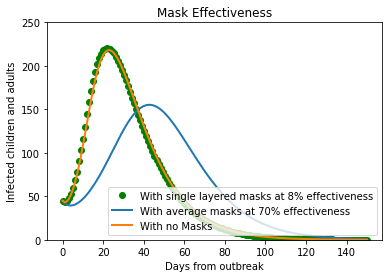

In [31]:
# Mask effectiveness on infection of total population 
mask = [1, .3, .92]
titles = ["With single layered masks at 8% effectiveness", "With average masks at 70% effectiveness", "With no Masks"]
#contact rate (individuals/day)
for i in range(3):
    cont_rate_c= 19
    cont_rate_a= 38

    #transmissibility of the disease
    trans_c = .061*mask[i]
    trans_a = .061*mask[i]

    #infectious perIod (days) 
    inf_period_c = 14
    inf_period_a = 14

    #incubation period (days)
    inc_period_c = 10
    inc_period_a = 14

    #
    mort_time_c = 42
    mort_time_a = 21


    # solve the system dy/dt = f(y, t)
    def f(y, t):
        #assign input vector,y to variables of the model
        S_c = y[0]
        I_c = y[1]
        R_c = y[2]
        E_c = y[3]
        D_c = y[4]
        S_a = y[5]
        I_a = y[6]
        R_a = y[7]
        E_a = y[8]
        D_a = y[9]
        
        # Calculate total population size,N
        N_c = I_c + S_c + R_c +E_c + D_c
        N_a =  I_a +S_a+R_a+E_a+D_a
        N= I_c + S_c + R_c +E_c + D_c + I_a +S_a+R_a+E_a+D_a

        # Parameters of SIR model
        r_r_c = 1/inf_period_c
        r_i_c = cont_rate_c*trans_c / N_c
        r_e_c = 1 / inc_period_c
        r_d_c = .003 / mort_time_c
        
        r_r_a = 1/inf_period_a
        r_i_a = cont_rate_a*trans_a / N_a
        r_e_a = 1 / inc_period_a
        r_d_a = .014 / mort_time_a
        
        # Fine right hand side of differential equations
        dS_c = (-r_i_c*S_c*(I_c + I_a)) 
        dI_c = r_e_c*E_c - r_r_c * I_c
        dR_c = r_r_c*I_c 
        dE_c = r_i_c *I_c*S_c - r_e_c*E_c 
        dD_c = r_i_c *I_c*S_c - r_e_c*E_c 
        
        dS_a = (-r_i_a*S_a*(I_c + I_a)) 
        dI_a = r_e_a*E_a - r_r_a * I_a
        dR_a = r_r_a*I_a 
        dE_a = r_i_a *I_a*S_a - r_e_a*E_a
        dD_a = r_i_a *I_a*S_a - r_e_a*E_a
        
        # output right-hand side of differetial equations
        return [dS_c, dI_c, dR_c, dE_c, dD_c, dS_a, dI_a, dR_a, dE_a, dD_a]


    # Choose total time of simulation, T
    T = 150

    # Chose time step
    dt = 1

    #Calculate number of time steps
    nsteps = int(T/dt)

    # Create time grid
    t  = np.linspace(0, T, nsteps) 

    # Choose initial conditions
    S0_c = 700.
    I0_c = 20.
    R0_c = 0.
    E0_c = 0
    D0_c = 0
    S0_a = 280.
    I0_a = 25.
    R0_a = 980. #(70% vaxed adults)
    E0_a = 0
    D0_a = 0
    

    y0 = [S0_c, I0_c, R0_c, E0_c, D0_c, S0_a, I0_a, R0_a, E0_a, D0_a]       


    # solve system of differential equations
    soln = odeint(f, y0, t)
    #print(soln)
    #assign solution vector,soln, to plotting variables
    S_c = soln[:, 0]
    I_c = soln[:, 1]
    R_c = soln[:, 2]
    E_c = soln[:, 3]
    D_c = soln[:, 4]
    S_a = soln[:, 5]
    I_a = soln[:, 6]
    R_a = soln[:, 7]
    E_a = soln[:, 8]
    D_a = soln[:, 9]

    S = S_c + S_a
    I = I_c + I_a
    R = R_c + R_a
    E = E_c + E_a
    D = D_c + D_a


    # plot results
    
    if mask[i] == 1:
        plt.plot(t, I, 'go', lw = 2, label = str(titles[i]),)
    else:
        plt.plot(t, I, lw = 2, label = str(titles[i]))

    plt.xlabel('Days from outbreak')
    plt.ylabel('Infected children and adults')
    plt.title('Mask Effectiveness')
    plt.ylim(0,250)

plt.legend(loc = 4)
plt.show()

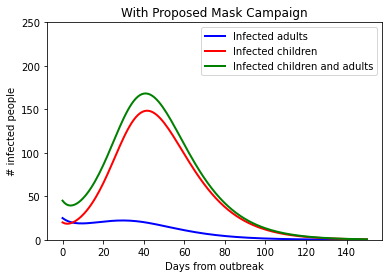

In [32]:
# Only implementing mask wearing campaign and seeing the effect on the total population
def step(t_1, t_2, t_3, t):
    if t < t_1:
        return .10
    elif t < t_2:
        return .4
    elif t < t_3:
        return .7
    else:
        return 1
    
t_1 = 14
t_2 = 28
t_3 = 42


#contact rate (individuals/day)
cont_rate_c= 19
cont_rate_a= 38

#transmissibility of the disease
trans_c = .061 * .3
trans_a = .061 * .3

#infectious perIod (days) 
inf_period_c = 14
inf_period_a = 14

#incubation period (days)
inc_period_c = 10
inc_period_a = 14

#
mort_time_c = 42
mort_time_a = 21

vac_rate = .02


# solve the system dy/dt = f(y, t)
def f(y, t):
        #assign input vector,y to variables of the model
        S_c = y[0]
        I_c = y[1]
        R_c = y[2]
        E_c = y[3]
        D_c = y[4]
        S_a = y[5]
        I_a = y[6]
        R_a = y[7]
        E_a = y[8]
        D_a = y[9]
        
        # Calculate total population size,N
        N_c = I_c + S_c + R_c +E_c + D_c
        N_a =  I_a +S_a+R_a+E_a+D_a
        N= I_c + S_c + R_c +E_c + D_c + I_a +S_a+R_a+E_a+D_a
        eligible = step(t_1, t_2, t_3, t)

        # Parameters of SIR model
        r_r_c = 1/inf_period_c
        r_i_c = cont_rate_c*trans_c / N_c
        r_e_c = 1 / inc_period_c
        r_d_c = .003 / mort_time_c
        r_v = .02 * eligible
        
        
        r_r_a = 1/inf_period_a
        r_i_a = cont_rate_a*trans_a / N_a
        r_e_a = 1 / inc_period_a
        r_d_a = .014 / mort_time_a
        
        # Fine right hand side of differential equations
        dS_c = (-r_i_c*S_c*(I_c + I_a)) 
        dI_c = r_e_c*E_c - r_r_c * I_c - r_d_c * I_c
        dR_c = r_r_c*I_c 
        dE_c = r_i_c *I_c*S_c - r_e_c*E_c 
        dD_c = r_d_c * I_c 
        
        dS_a = (-r_i_a*S_a*(I_c + I_a)) 
        dI_a = r_e_a*E_a - r_r_a * I_a - r_d_a * I_a
        dR_a = r_r_a*I_a 
        dE_a = r_i_a *I_a*S_a - r_e_a*E_a
        dD_a = r_d_a * I_a
        
        # output right-hand side of differetial equations
        return [dS_c, dI_c, dR_c, dE_c, dD_c, dS_a, dI_a, dR_a, dE_a, dD_a]


# Choose total time of simulation, T
T = 150

# Chose time step
dt = 1

#Calculate number of time steps
nsteps = int(T/dt)

# Create time grid
t  = np.linspace(0, T, nsteps) 

# Choose initial conditions
S0_c = 700.
I0_c = 20.
R0_c = 0.
E0_c = 0
D0_c = 0
S0_a = 280.
I0_a = 25.
R0_a = 980. #(70% vaxed adults)
E0_a = 0
D0_a = 0


y0 = [S0_c, I0_c, R0_c, E0_c, D0_c, S0_a, I0_a, R0_a, E0_a, D0_a]       


# solve system of differential equations
soln = odeint(f, y0, t)
#print(soln)
#assign solution vector,soln, to plotting variables
S_c = soln[:, 0]
I_c = soln[:, 1]
R_c = soln[:, 2]
E_c = soln[:, 3]
D_c = soln[:, 4]
S_a = soln[:, 5]
I_a = soln[:, 6]
R_a = soln[:, 7]
E_a = soln[:, 8]
D_a = soln[:, 9]

S = S_c + S_a
I = I_c + I_a
R = R_c + R_a
E = E_c + E_a
D = D_c + D_a


# plot results
plt.figure()

plt.plot(t, I_a, lw = 2, color = 'blue'  , label = 'Infected adults')
plt.plot(t, I_c, lw = 2, color = 'red', label = 'Infected children')
plt.plot(t, I, lw = 2, color = 'green', label = 'Infected children and adults')

plt.xlabel('Days from outbreak')
plt.ylabel('# infected people')
plt.title('With Proposed Mask Campaign')
plt.ylim(0, 250)

plt.legend(loc=0)
plt.show()

# Implementing both the phased vaccine campaign and mask campaign

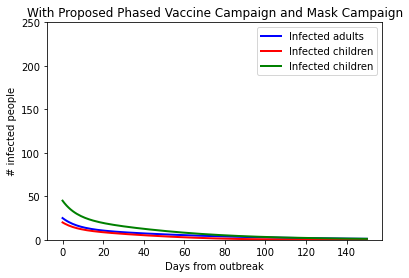

In [33]:
#With proposed phased vaccine campaign and mask campaign together 
#contact rate (individuals/day)
cont_rate_c= 19
cont_rate_a= 38

#transmissibility of the disease
trans_c = .061 * .1
trans_a = .061 * .1

#infectious perIod (days) 
inf_period_c = 14
inf_period_a = 14

#incubation period (days)
inc_period_c = 10
inc_period_a = 14

#
mort_time_c = 42
mort_time_a = 21

vac_rate = .02


# solve the system dy/dt = f(y, t)
def f(y, t):
        #assign input vector,y to variables of the model
        S_c = y[0]
        I_c = y[1]
        R_c = y[2]
        E_c = y[3]
        D_c = y[4]
        S_a = y[5]
        I_a = y[6]
        R_a = y[7]
        E_a = y[8]
        D_a = y[9]
        
        # Calculate total population size,N
        N_c = I_c + S_c + R_c +E_c + D_c
        N_a =  I_a +S_a+R_a+E_a+D_a
        N= I_c + S_c + R_c +E_c + D_c + I_a +S_a+R_a+E_a+D_a
        eligible = step(t_1, t_2, t_3, t)

        # Parameters of SIR model
        r_r_c = 1/inf_period_c
        r_i_c = cont_rate_c*trans_c / N_c
        r_e_c = 1 / inc_period_c
        r_d_c = .003 / mort_time_c
        r_v = .02 * eligible
        
        
        r_r_a = 1/inf_period_a
        r_i_a = cont_rate_a*trans_a / N_a
        r_e_a = 1 / inc_period_a
        r_d_a = .014 / mort_time_a
        
        # Fine right hand side of differential equations
        dS_c = (-r_i_c*S_c*(I_c + I_a)) - r_v * S_c
        dI_c = r_e_c*E_c - r_r_c * I_c
        dR_c = r_r_c*I_c + r_v * S_c
        dE_c = r_i_c *I_c*S_c - r_e_c*E_c 
        dD_c = r_i_c *I_c*S_c - r_e_c*E_c 
        
        dS_a = (-r_i_a*S_a*(I_c + I_a)) 
        dI_a = r_e_a*E_a - r_r_a * I_a
        dR_a = r_r_a*I_a 
        dE_a = r_i_a *I_a*S_a - r_e_a*E_a
        dD_a = r_i_a *I_a*S_a - r_e_a*E_a
        
        # output right-hand side of differetial equations
        return [dS_c, dI_c, dR_c, dE_c, dD_c, dS_a, dI_a, dR_a, dE_a, dD_a]


# Choose total time of simulation, T
T = 150

# Chose time step
dt = 1

#Calculate number of time steps
nsteps = int(T/dt)

# Create time grid
t  = np.linspace(0, T, nsteps) 

# Choose initial conditions
S0_c = 280.
I0_c = 20.
R0_c = 420.
E0_c = 0
D0_c = 0
S0_a = 280.
I0_a = 25.
R0_a = 980. #(70% vaxed adults)
E0_a = 0
D0_a = 0


y0 = [S0_c, I0_c, R0_c, E0_c, D0_c, S0_a, I0_a, R0_a, E0_a, D0_a]       


# solve system of differential equations
soln = odeint(f, y0, t)
#print(soln)
#assign solution vector,soln, to plotting variables
S_c = soln[:, 0]
I_c = soln[:, 1]
R_c = soln[:, 2]
E_c = soln[:, 3]
D_c = soln[:, 4]
S_a = soln[:, 5]
I_a = soln[:, 6]
R_a = soln[:, 7]
E_a = soln[:, 8]
D_a = soln[:, 9]

S = S_c + S_a
I = I_c + I_a
R = R_c + R_a
E = E_c + E_a
D = D_c + D_a


# plot results
plt.figure()

plt.plot(t, I_a, lw = 2, color = 'blue'  , label = 'Infected adults')
plt.plot(t, I_c, lw = 2, color = 'red', label = 'Infected children')
plt.plot(t, I_c + I_a, lw = 2, color = 'green', label = 'Infected children')

plt.xlabel('Days from outbreak')
plt.ylabel('# infected people')
plt.title('With Proposed Phased Vaccine Campaign and Mask Campaign')
plt.ylim(0, 250)

plt.legend(loc=0)
plt.show()